# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Jan 27 11:35:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [4]:
!pip install bert-extractive-summarizer

In [5]:
!pip install pytorch-ignite
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 10.9 MB/s eta 0:00:00


## importowanie datesetu

In [6]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [7]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [8]:
from summarizer import Summarizer
model = Summarizer()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [32]:
num_workers = 1
batch_size = 50

In [33]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(250))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 250
})


In [12]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    print(f"Doc: {batch['document'][0][:100]}")
    print(f"Prediction: {predictions[0]}")
    print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]

    print(predictions)
    print(targets)

    m.update((predictions, targets))
    print(m.compute())
    return m.compute()

In [13]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ]):
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=f'Model {i+1}')
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [14]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [15]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [16]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
) -> float:
    results = []

    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [17]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
        )

    return loss




In [34]:
from torch import nn
loss = evaluate_model(model, test_loader, device='cuda', bert=True, tokenizer=None)
print(loss)



Doc: The victim was attacked because her son had eloped with an upper-caste girl about a month ago.
She h
Prediction: The victim was attacked because her son had eloped with an upper-caste girl about a month ago. On Wednesday, police arrested five people, including the eloped girl's parents.
Target: Police in India's Maharashtra state have arrested five members of an upper caste for beating, stripping and parading naked a low-caste Dalit woman.
[['the', 'victim', 'was', 'attacked', 'because', 'her', 'son', 'had', 'eloped', 'with', 'an', 'upper', 'caste', 'girl', 'about', 'a', 'month', 'ago', 'on', 'wednesday', 'police', 'arrested', 'five', 'people', 'including', 'the', 'eloped', 'girl', 's', 'parents'], ['the', '45', 'year', 'old', 'who', 'had', 'a', 'spell', 'as', 'a', 'player', 'at', 'headingley', 'between', '1990', 'and', '1995', 'spent', 'eight', 'years', 'as', 'essex', 'coach', 'before', 'leaving', 'at', 'the', 'end', 'of', '2015', 'yorkshire', 'diamonds', 'will', 'start', 'their'

In [19]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=4, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [21]:
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-ve9yq0i3/unsloth-zoo_69ed7a80a2344d8aadffc12a7e9c58d2
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-ve9yq0i3/unsloth-zoo_69ed7a80a2344d8aadffc12a7e9c58d2
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit bb2375ec6ebe00c65cfffc8f533a14b293646d11
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 230.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 402.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 390.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 377.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-3bighdqx/unsloth_a5e28e52723a4a5b8e651e7e4731def8
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-3bighdqx/unsloth_a5e28e52723a4a5b8e651e7e4731def8
  Resolved https://github.com/unslothai/unsloth.git to commit 4cb7229ac1c346e143524b6f9a6ad544259364d6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.2 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412535 sha256=1361e4366570c7e0aab1842cde35d9469462379ae8ea722b43b9e47b340a05b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-e8r0n3bb/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel
model3, tokenizer3 = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=32000, load_in_4bit=False
)




==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.


In [25]:
prompt3 = generate_prompt(tokenizer3, 3)
print(prompt3)

[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The Hartswood Films production beat the likes of EastEnders, Strictly Come Dancing, The Great British Bake Off and Game of Thrones.
But its star, Benedict Cumberbatch, lost out on the best actor prize for a third time.
The honour went instead to Jason Watkins, for his role in The Lost Honour of Christopher Jefferies.
Backstage at the Sunday night ceremony , Sherlock writer Steven Moffat confirmed three new episodes would be filmed next spring.[AGENT]BBC Wales' detective drama Sherlock has won the Radio Times audience award at the Baftas.<|endoftext|>
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The Glasgow-based company said it had acquired Colton Packaging Teesside in a deal worth up to £1.25m.
Colton was part of Colton Packaging, an established regional distributor of protective packaging materials based in Leicester.
Last ye

In [ ]:

data = evaluate_model(model3, test_loader, device='cuda', bert=False, tokenizer=tokenizer3, prompt=prompt3, promptsuff = "[AGENT]")

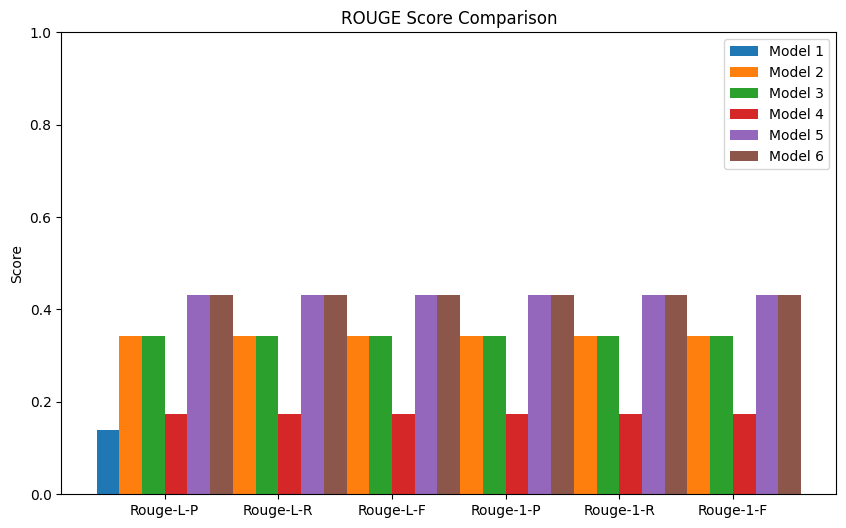

In [ ]:
plot_data(data)

In [ ]:
prompt4 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model3,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer3,
        prompt=prompt4,
        promptsuff = "[AGENT]"
    )


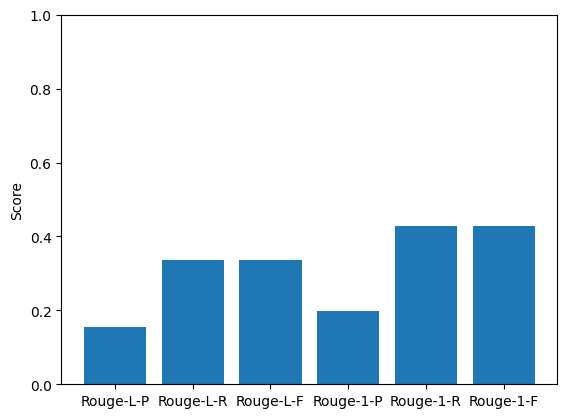

In [ ]:
plot_data(data_zero_shot)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model3, model_path)


In [ ]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer3, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

In [ ]:
plot_data([data_ft, data, data_zero_shot, loss])
print(data_zero_shot)
print(data_ft)